<a href="https://colab.research.google.com/github/Nhlanhla-Mackenzie-30/MIT805Project/blob/main/mit805_kenzie_final_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install PySpark
!pip install pyspark
#Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, when, sum as spark_sum, max as spark_max, min as spark_min, to_date, date_format
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import os
from PIL import Image
from collections import defaultdict, Counter







     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=6d83f221be994c2bcb67af866a131b0e927c28b4a0634301f34ff6836ee060a4
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
!kaggle datasets download maparla/zara-products


Dataset URL: https://www.kaggle.com/datasets/maparla/zara-products
License(s): MIT
100% 11.6G/11.6G [02:54<00:00, 57.0MB/s]
100% 11.6G/11.6G [02:54<00:00, 71.2MB/s]


In [ ]:
!unzip zara-products.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/zara/cb731fe9-938f-457d-b2ba-0dd7e5679913.jpg  
  inflating: images/zara/cb74fbd8-f135-43bc-8995-4f09dabfffca.jpg  
  inflating: images/zara/cb75bbc9-31db-4463-b213-cd8abc6dabb4.jpg  
  inflating: images/zara/cb77d387-c404-4771-92cb-cf61329a47cf.jpg  
  inflating: images/zara/cb78c174-954b-4927-9dc2-9685bc456a24.jpg  
  inflating: images/zara/cb7ba70e-0a54-4fa5-b417-fe6bde46809d.jpg  
  inflating: images/zara/cb7f4a44-97c1-44ea-b647-c3d805f49e92.jpg  
  inflating: images/zara/cb840156-b8c7-4c7c-8c20-d2c44a31ad5c.jpg  
  inflating: images/zara/cb8979d6-9230-464b-9746-309ed15f89c7.jpg  
  inflating: images/zara/cb8bc856-fc20-4e20-938a-0b5bef26787e.jpg  
  inflating: images/zara/cb8d005c-ed64-4555-8d43-81aee2123b27.jpg  
  inflating: images/zara/cb8eb79a-eba6-4b11-b814-70e35c3de710.jpg  
  inflating: images/zara/cb92151c-80cd-4899-9222-926b072ccab3.jpg  
  inflating: images/zara/cb94859f-ce68-4722-968a-4d6af0bb6abb.jpg

In [ ]:
# Create Spark Session
spark = SparkSession.builder \
    .appName("Zara Products Analysis") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

Total number of images: 25055
Most common image format: JPEG
Max Image Dimensions: 1920x2904
Min Image Dimensions: 643x964
Average Image Dimensions: 1919x2878


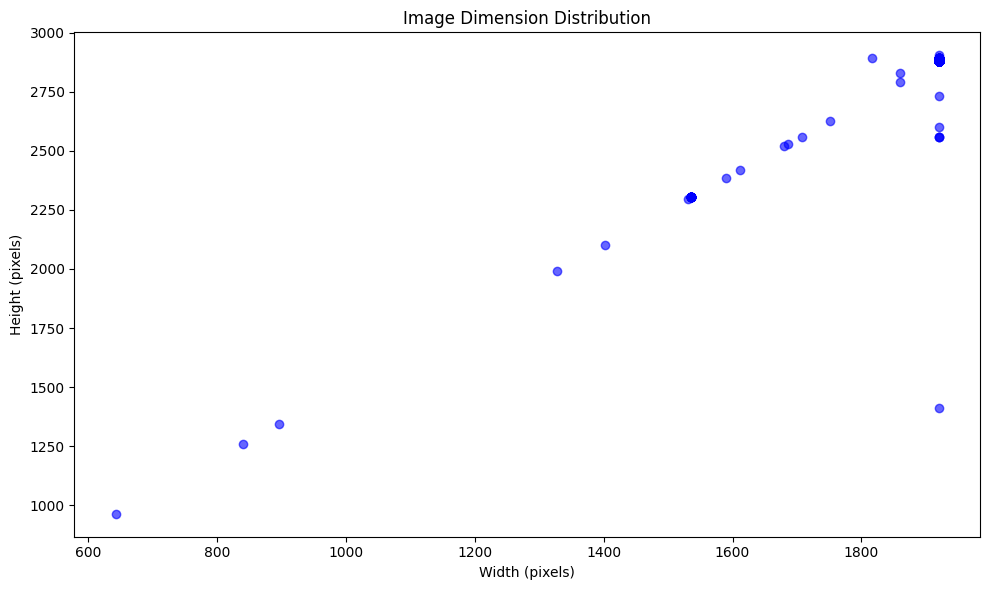

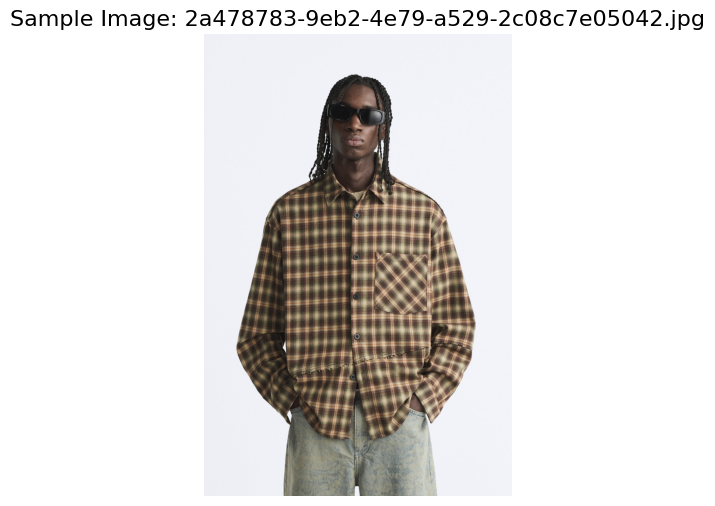

In [ ]:
# Path to the image folder
image_folder_path = "/content/images/zara"

# Map function:
def map_image_info(image_path):
    try:
        # Open the image
        img = Image.open(image_path)

        # Extract the format and dimensions
        img_format = img.format
        img_size = img.size

        return (img_format, img_size)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Get the list of all image files in the directory
image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]

# Count the total number of images
total_images = len(image_files)
print(f"Total number of images: {total_images}")

# Map phase: Apply map_image_info to each image file
mapped_results = []
for img_file in image_files:
    img_path = os.path.join(image_folder_path, img_file)
    result = map_image_info(img_path)
    if result:
        mapped_results.append(result)

# Reduce function: Aggregating information for formats and sizes
def reduce_image_info(mapped_data):
    # To count the image formats
    format_counter = Counter()
    # To aggregate image dimensions by width and height
    size_aggregator = defaultdict(list)

    for img_format, img_size in mapped_data:
        # Reduce step for format: Count occurrences of each format
        format_counter[img_format] += 1

        # Reduce step for size: Collect all widths and heights separately
        width, height = img_size
        size_aggregator['width'].append(width)
        size_aggregator['height'].append(height)

    return format_counter, size_aggregator

# Reduce phase: Get the aggregated format counts and size information
format_counts, size_info = reduce_image_info(mapped_results)


# Insight 1: Most common image format
most_common_format = format_counts.most_common(1)[0][0]
print(f"Most common image format: {most_common_format}")

# Insight 2: Image dimensions statistics (max, min, average)
max_width, max_height = max(size_info['width']), max(size_info['height'])
min_width, min_height = min(size_info['width']), min(size_info['height'])
avg_width = np.mean(size_info['width'])
avg_height = np.mean(size_info['height'])

print(f"Max Image Dimensions: {max_width}x{max_height}")
print(f"Min Image Dimensions: {min_width}x{min_height}")
print(f"Average Image Dimensions: {int(avg_width)}x{int(avg_height)}")

# Visualization: Distribution of Image Dimensions
plt.figure(figsize=(10, 6))
plt.scatter(size_info['width'], size_info['height'], alpha=0.6, color='blue')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Dimension Distribution')
plt.tight_layout()
plt.show()

# Display a sample image
sample_image_path = os.path.join(image_folder_path, image_files[0])
sample_image = Image.open(sample_image_path)

# Show the sample image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.axis('off')
plt.title(f"Sample Image: {image_files[0]}", fontsize=16)
plt.show()



+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----------+------------------+----------+-------+-----------+---------------+
|summary|               brand|                 url|                 sku|                name|         description|            price|            currency|     images|        scraped_at|     terms|section|      error|image_downloads|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----------+------------------+----------+-------+-----------+---------------+
|  count|                4706|                4361|                4349|                4276|                4264|             3133|                3133|       2070|              3053|      2028|   1985|         14|           1940|
|   mean|                NULL|   66.32861451460954|   75.38805194805191|

<ipython-input-10-07311a76ec3b>:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_category_pd, x='section', y='total_sales', palette='muted')


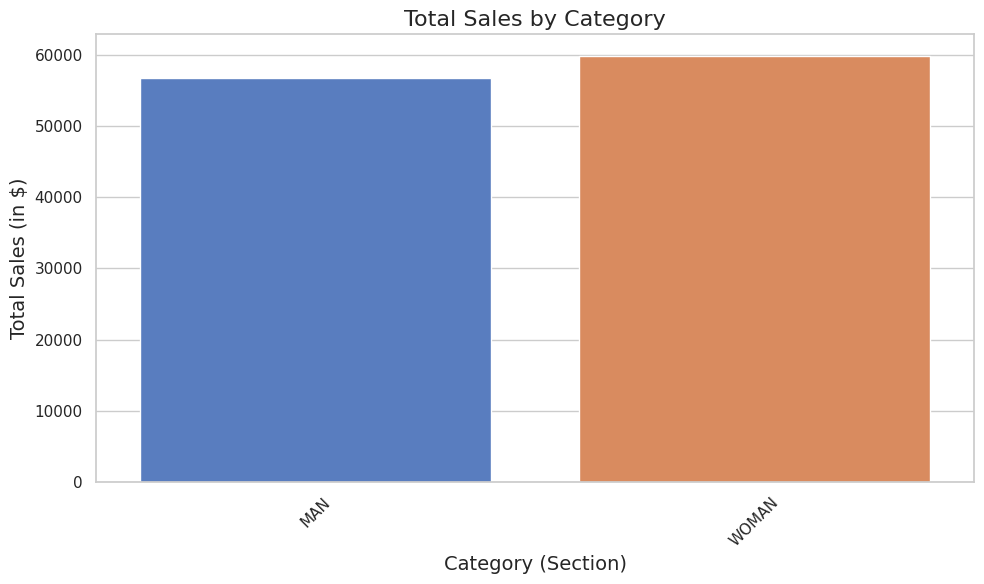

Top Selling Products:
+--------------------+------------------+
|                name|       total_sales|
+--------------------+------------------+
|DOUBLE FACED 100%...|             869.0|
|BELTED LEATHER CO...|             699.0|
|ASYMMETRIC DRESS ...|             489.0|
|LIMITED EDITION L...|             477.0|
|    TEXTURED SWEATER|465.19999999999993|
|BELTED LEATHER DR...|             439.0|
|BELTED LEATHER BL...|             439.0|
|CROPPED LEATHER J...|             439.0|
| MULTIPIECE SNEAKERS|435.29999999999995|
|UTILITY POCKET JEANS|             429.5|
+--------------------+------------------+



<ipython-input-10-07311a76ec3b>:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_selling_products_pd, x='name', y='total_sales', palette='rocket')


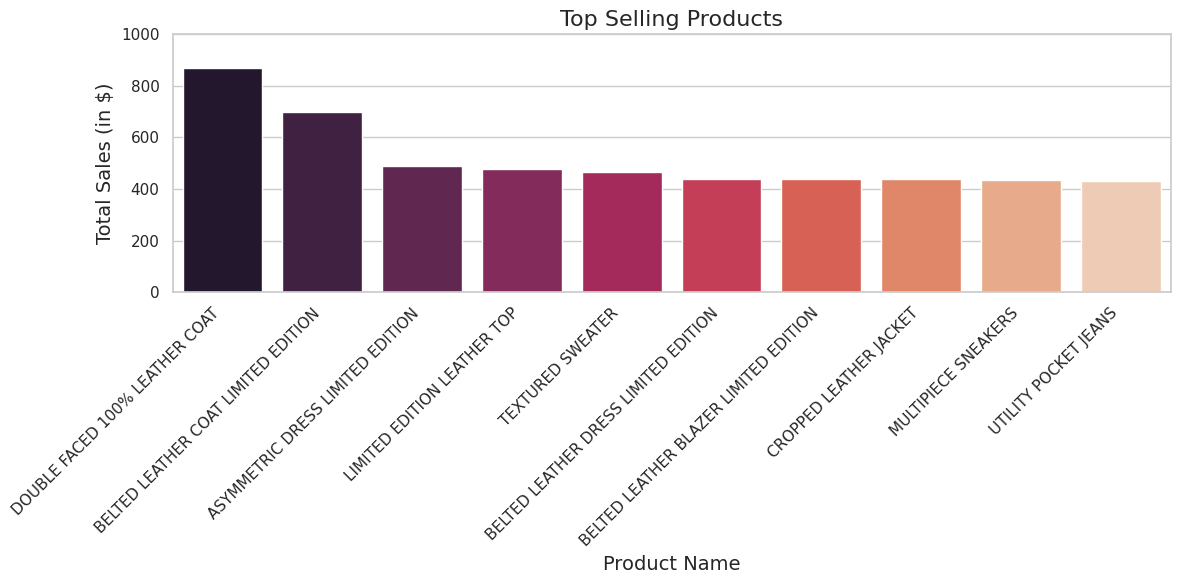

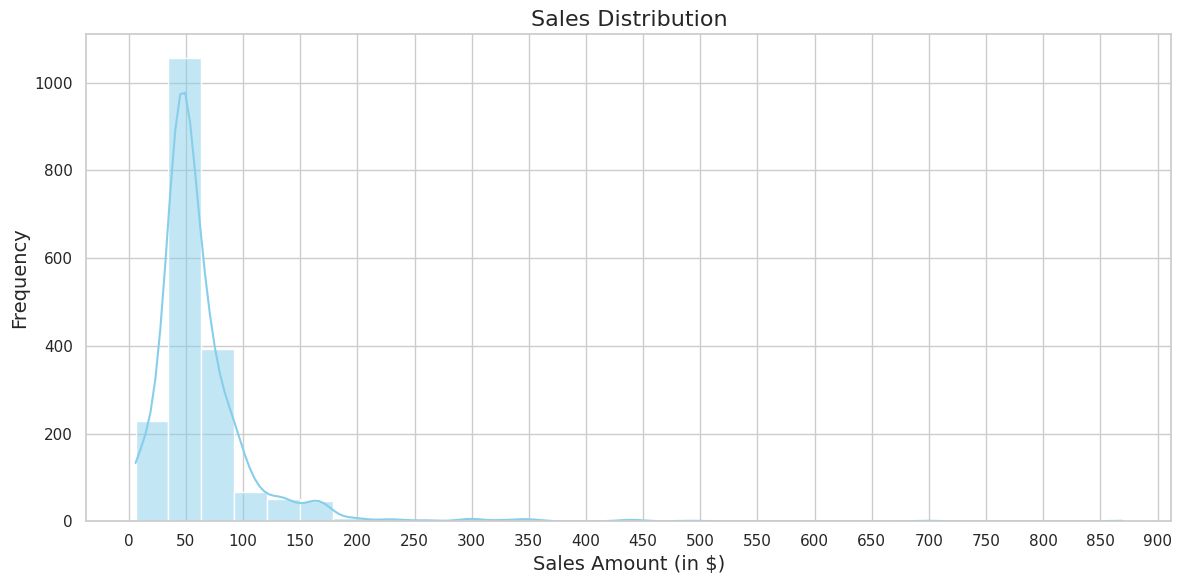

<ipython-input-10-07311a76ec3b>:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_store_pd, x='section', y='price', palette='muted')


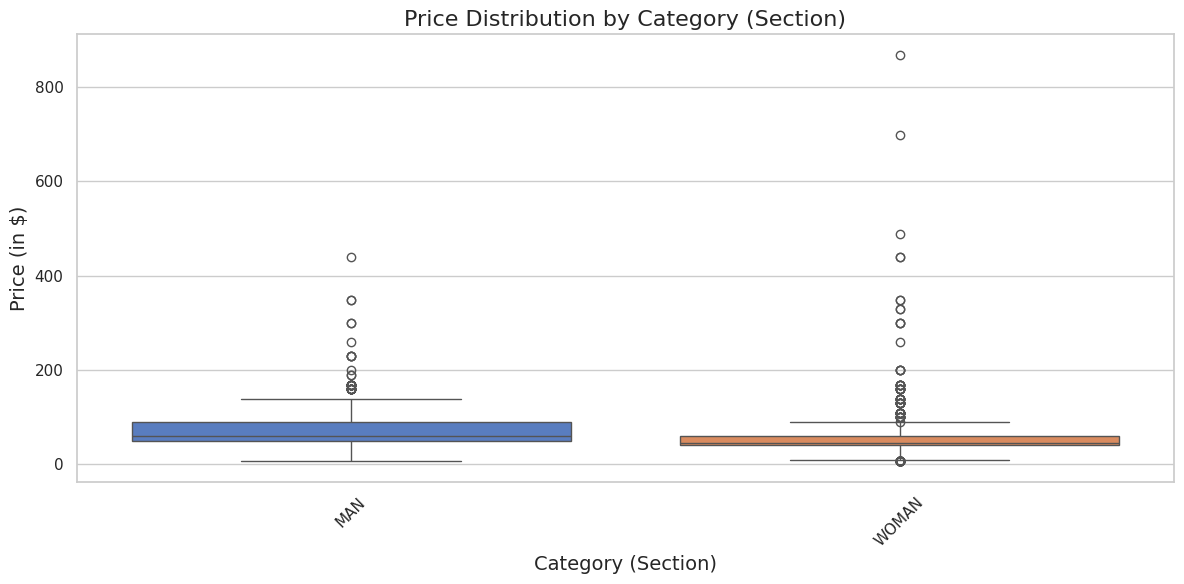

<Figure size 1200x600 with 0 Axes>

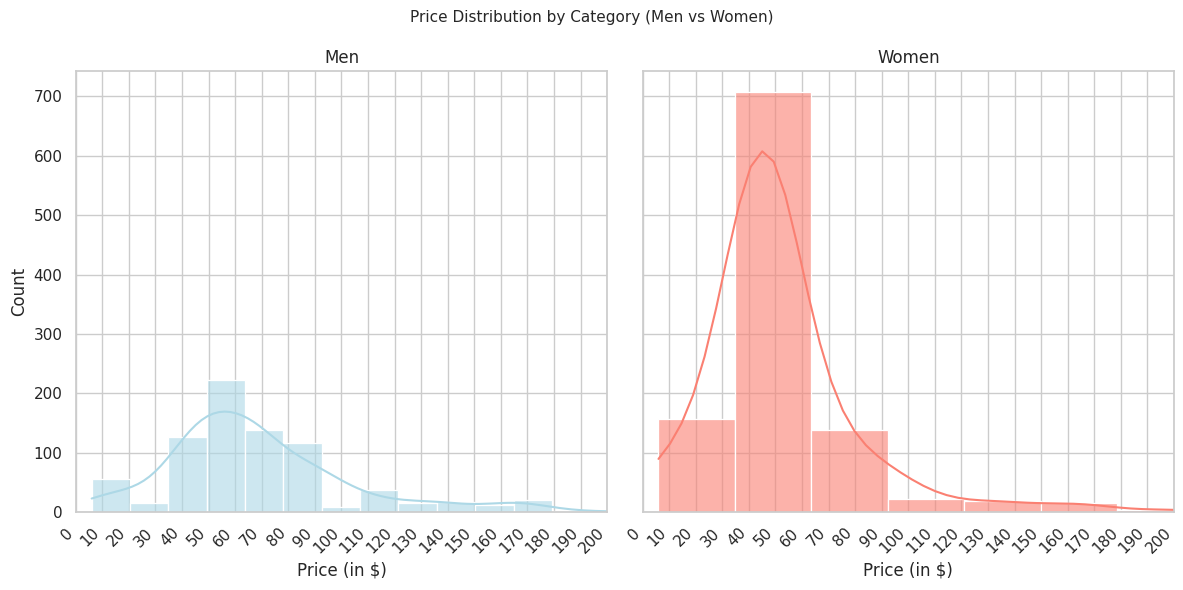

In [ ]:
# Set a consistent visual style for plots
sns.set(style="whitegrid")


# Load CSV Data (store data)
csv_path = "/content/store_zara.csv"  # Update path as needed
store_zara_df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Basic statistics for CSV dataset
store_zara_df.describe().show()

# Load JSON Data with schema (search data)
json_path = "/content/searches_zara.json"  # Update path as needed
schema = StructType([
    StructField("id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("price", DoubleType(), True),
    StructField("category", StringType(), True),
    StructField("timestamp", StringType(), True)
])
zara_products_df = spark.read.schema(schema).json(json_path)

# Show schema and total records loaded
print("Zara Products JSON Schema:")
zara_products_df.printSchema()
total_records = zara_products_df.count()
print(f"Total JSON records loaded: {total_records}")

# Missing data analysis for CSV
missing_data_df = store_zara_df.select([count(when(col(c).isNull(), c)).alias(c) for c in store_zara_df.columns])
print("Missing data in CSV columns:")
missing_data_df.show()

# Data Cleaning - Remove rows with null values in important columns for CSV
cleaned_store_df = store_zara_df.na.drop(subset=["sku", "name", "price", "section"])

# Remove invalid prices (e.g., price < 0 or too high)
cleaned_store_df = cleaned_store_df.filter((col('price') > 0) & (col('price') < 1000))

# Show cleaned CSV data
print("Cleaned CSV Data:")
cleaned_store_df.show()

# Missing data analysis for JSON
null_counts = zara_products_df.select([count(when(col(c).isNull(), c)).alias(c) for c in ['id', 'name', 'price', 'category']])
print("Missing data in JSON columns:")
null_counts.show()

# Data cleaning for JSON
cleaned_zara_df = zara_products_df.na.drop(subset=["id", "name", "price", "category"])

# Count valid records after cleaning
valid_records_count = cleaned_zara_df.count()
print(f"Valid JSON records after cleaning: {valid_records_count}")

# Insights for CSV

# Max and Min prices in the CSV dataset by section
price_range_df = cleaned_store_df.groupBy("section").agg(
    spark_max("price").alias("max_price"),
    spark_min("price").alias("min_price")
)
print("Max and Min Price by Section in CSV:")
price_range_df.show()

# Advanced Analytics: Price Distribution and Average Price per Section
avg_price_section_df = cleaned_store_df.groupBy("section").agg(avg("price").alias("average_price"))
print("Average Price by Section:")
avg_price_section_df.show()

# Store Performance Analytics

# Total Revenue by Section
total_revenue_df = cleaned_store_df.groupBy("section").agg(spark_sum("price").alias("total_revenue"))
print("Total Revenue by Section:")
total_revenue_df.show()

# Average Order Value (AOV)
total_orders = cleaned_store_df.count()
total_revenue_value = total_revenue_df.select(spark_sum("total_revenue")).first()[0]
average_order_value = total_revenue_value / total_orders if total_orders > 0 else 0
print(f"Average Order Value (AOV): ${average_order_value:.2f}")

# Check if timestamp exists and retrieve daily sales performance
if 'timestamp' in cleaned_zara_df.columns:
    # Ensure that the timestamp can be converted to date
    cleaned_zara_df = cleaned_zara_df.withColumn("date", to_date(col("timestamp"), "yyyy-MM-dd"))

    # Check for valid dates
    valid_dates_count = cleaned_zara_df.filter(col("date").isNotNull()).count()
    print(f"Valid dates available for daily sales performance: {valid_dates_count}")

    if valid_dates_count > 0:
        daily_sales_df = cleaned_zara_df.groupBy("date").agg(spark_sum("price").alias("daily_revenue")).orderBy("date")

        print("Daily Sales Performance:")
        daily_sales_df.show()

        # Visualization: Daily Sales Performance
        daily_sales_pd = daily_sales_df.toPandas()

        plt.figure(figsize=(12, 6))
        sns.lineplot(data=daily_sales_pd, x='date', y='daily_revenue', marker='o')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Daily Revenue (in $)', fontsize=14)
        plt.title('Daily Sales Performance', fontsize=16)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid dates available for daily sales performance.")
else:
    print("Timestamp column not found in JSON data.")

# More Data analytics Insights

# 1. Sales by Category
sales_by_category_df = cleaned_store_df.groupBy("section").agg(spark_sum("price").alias("total_sales"))
print("Sales by Category:")
sales_by_category_df.show()

# Visualization: Sales by Category
sales_by_category_pd = sales_by_category_df.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_category_pd, x='section', y='total_sales', palette='muted')
plt.xlabel('Category (Section)', fontsize=14)
plt.ylabel('Total Sales (in $)', fontsize=14)
plt.title('Total Sales by Category', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Top Selling Products
top_selling_products_df = cleaned_store_df.groupBy("name").agg(spark_sum("price").alias("total_sales")).orderBy("total_sales", ascending=False).limit(10)
print("Top Selling Products:")
top_selling_products_df.show()

# Visualization: Top Selling Products
top_selling_products_pd = top_selling_products_df.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_selling_products_pd, x='name', y='total_sales', palette='rocket')

# Adjust x-axis labels to be readable
plt.xlabel('Product Name', fontsize=14)
plt.ylabel('Total Sales (in $)', fontsize=14)
plt.title('Top Selling Products', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Set the limits of the y-axis to go up to 1000
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()

# 3. Average Price Trends Over Time
if valid_dates_count > 0:
    avg_price_trend_df = cleaned_zara_df.groupBy("date").agg(avg("price").alias("average_price")).orderBy("date")
    print("Average Price Trends Over Time:")
    avg_price_trend_df.show()

    # Visualization: Average Price Trends
    avg_price_trend_pd = avg_price_trend_df.toPandas()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=avg_price_trend_pd, x='date', y='average_price', marker='o')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Average Price (in $)', fontsize=14)
    plt.title('Average Price Trends Over Time', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Sales Distribution

# Ensure price column is numeric
cleaned_store_pd = cleaned_store_df.toPandas()
cleaned_store_pd['price'] = pd.to_numeric(cleaned_store_pd['price'], errors='coerce')

# Ensure price column is numeric
cleaned_store_pd['price'] = pd.to_numeric(cleaned_store_pd['price'], errors='coerce')

# 4. Sales Distribution
plt.figure(figsize=(12, 6))
sns.histplot(cleaned_store_pd['price'], bins=30, kde=True, color='skyblue')
plt.xlabel('Sales Amount (in $)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Sales Distribution', fontsize=16)

# Set x-ticks to better represent the price range
max_price = cleaned_store_pd['price'].max()
plt.xticks(np.arange(0, max_price + 50, 50))

plt.tight_layout()
plt.show()


# Price Distribution by Category Visualization
plt.figure(figsize=(12, 6))

# Create a boxplot to show price distribution by category
sns.boxplot(data=cleaned_store_pd, x='section', y='price', palette='muted')
plt.xlabel('Category (Section)', fontsize=14)
plt.ylabel('Price (in $)', fontsize=14)
plt.title('Price Distribution by Category (Section)', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Set up the figure
plt.figure(figsize=(12, 6))

# Men and women price data
men_prices = cleaned_store_pd[cleaned_store_pd['section'] == 'MAN']['price']
women_prices = cleaned_store_pd[cleaned_store_pd['section'] == 'WOMAN']['price']

# Use separate subplots for men and women with shared y-axis
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Histogram for men
sns.histplot(men_prices, kde=True, color='lightblue', label='Men', alpha=0.6, ax=axs[0], bins=30)
axs[0].set_title('Men')
axs[0].set_xlabel('Price (in $)')
axs[0].set_xlim(0, 200)

# Histogram for women
sns.histplot(women_prices, kde=True, color='salmon', label='Women', alpha=0.6, ax=axs[1], bins=30)
axs[1].set_title('Women')
axs[1].set_xlabel('Price (in $)')
axs[1].set_xlim(0, 200)

# Update overall title and labels
plt.suptitle('Price Distribution by Category (Men vs Women)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)

# Fix the x-axis: rotate labels and adjust the ticks
for ax in axs:
    ax.set_xticks(np.arange(0, 201, 10))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


# Stop the Spark session
spark.stop()


